# **1. Introduction**

Since the topic requires us to predict the top_category_id and the bottom_category_id, let's first visually look at the distribution of the top_category_id：

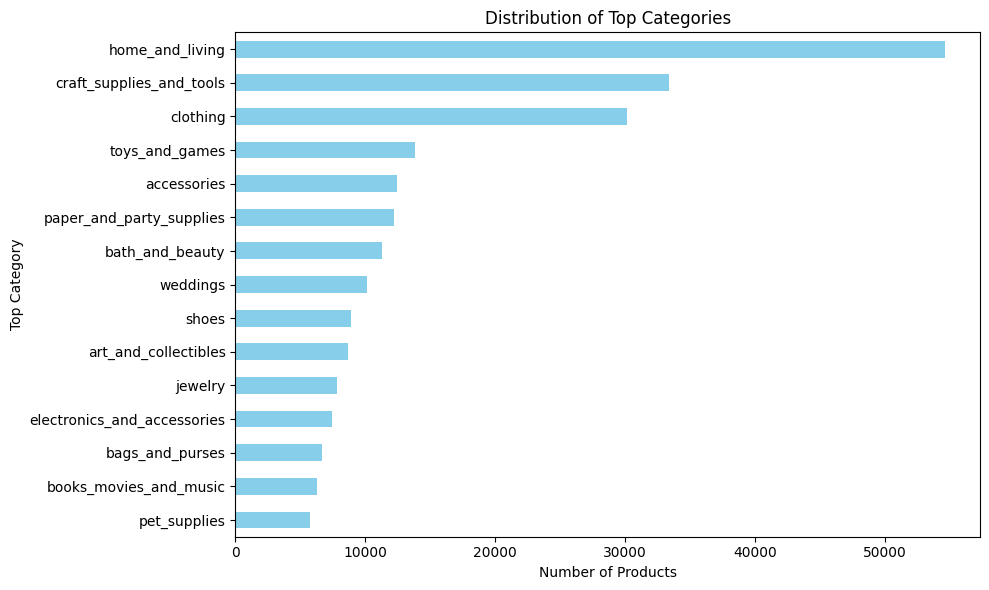

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = r"/content/drive/MyDrive/2025/train"


df_list = []
for file in os.listdir(folder_path):
    if file.endswith(".parquet"):
        full_path = os.path.join(folder_path, file)
        df = pd.read_parquet(full_path)
        df_list.append(df)


all_data = pd.concat(df_list, ignore_index=True)


top_category_counts = all_data['top_category_text'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
top_category_counts.plot(kind='barh', color='skyblue')
plt.xlabel("Number of Products")
plt.ylabel("Top Category")
plt.title("Distribution of Top Categories")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Now the number of items in 15 categories is displayed by code. As shown in the figure, top_category has 15 categories, so it is relatively easy to predict.

However, the distribution of data in this graph is uneven, and we need to pay attention to solving these uneven distribution problems when using the model.

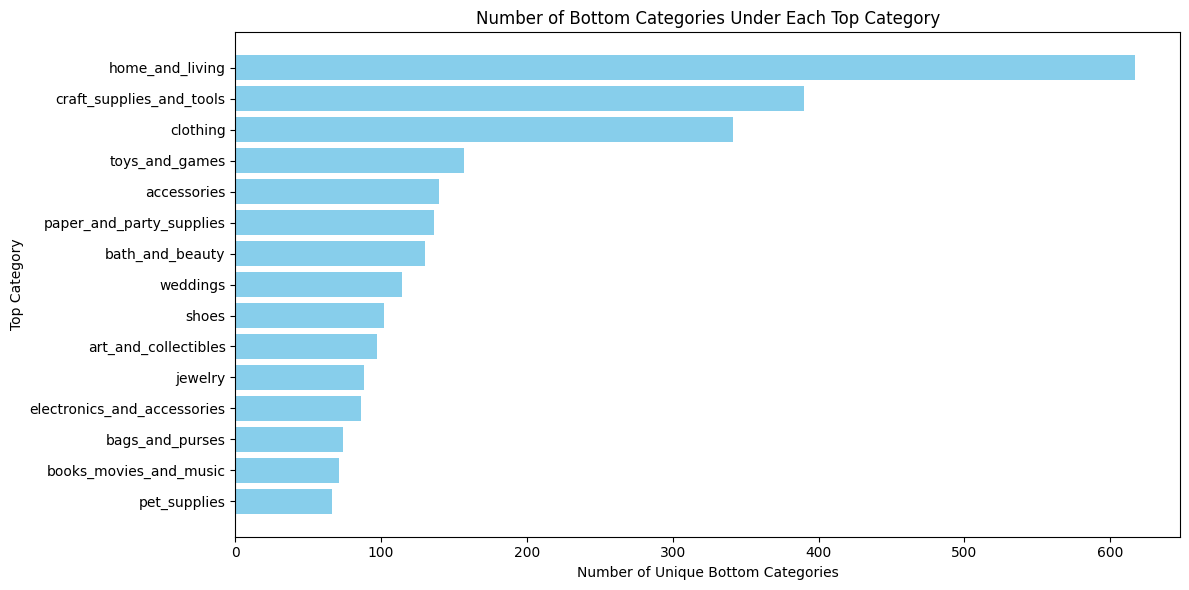

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt


folder_path = r"/content/drive/MyDrive/2025/train"


df_list = []
for file in os.listdir(folder_path):
    if file.endswith(".parquet"):
        full_path = os.path.join(folder_path, file)
        df = pd.read_parquet(full_path)
        df_list.append(df)


all_data = pd.concat(df_list, ignore_index=True)

category_mapping = {}

for _, row in all_data.iterrows():
    top_category = row["top_category_text"]
    bottom_category = row["bottom_category_text"]


    if top_category in bottom_category:
        if top_category not in category_mapping:
            category_mapping[top_category] = set()
        category_mapping[top_category].add(bottom_category)

category_counts = {key: len(value) for key, value in category_mapping.items()}
category_df = pd.DataFrame(category_counts.items(), columns=["Top Category", "Number of Bottom Categories"])
category_df = category_df.sort_values(by="Number of Bottom Categories", ascending=False)


plt.figure(figsize=(12, 6))
plt.barh(category_df["Top Category"], category_df["Number of Bottom Categories"], color="skyblue")
plt.xlabel("Number of Unique Bottom Categories")
plt.ylabel("Top Category")
plt.title("Number of Bottom Categories Under Each Top Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


By examining the dataset, we have observed that if the `top_category_text` is **toys_and_games**, then the `bottom_category_text` also starts with **toys_and_games**.  

This chart calculates the number of subcategories for each top category based on the relationship between `bottom_category_text` and `top_category_text`.  

As you can see, there are a large number of subcategories, making it naturally more challenging to predict.


# **2. Methods**



To improve the prediction of `top_category` and `bottom_category`, we aim to address the following key challenges:

- **Challenge 1**: How to handle imbalanced data distribution?  
- **Challenge 2**: How to deal with the difficulty of predicting `bottom_category` due to its large number of classes?  
- **Challenge 3**: Is there a performance difference (e.g., F1 score) between using **fine-tuning** and **frozen pre-trained embeddings**?

To investigate these questions, I built **three models**:

1. **Baseline Model: Frozen BERT + Logistic Regression**  
   This model uses pre-trained DistilBERT embeddings without fine-tuning. It serves as a lightweight baseline to compare against more advanced methods.

2. **Fine-tuned Model for Top Category Prediction**  
   This model fine-tunes DistilBERT on the `top_category` prediction task. It incorporates both text and categorical features and uses class weighting to address data imbalance.

3. **Fine-tuned Model for Bottom Category with Top Correction**  
   In this model, I first predict `top_category` using the second model. Then, the predicted top category is used to filter possible bottom categories, improving the precision of `bottom_category` prediction.

I will demonstrate how each model is implemented and how these strategies help overcome the challenges mentioned above in the following sections.


# **3. Baseline Model: Frozen BERT + Logistic Regression**

**baseline_frozen_bert_logistic.py**

In [ ]:


import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


TRAIN_DIR =  r"/content/drive/MyDrive/2025/train"


all_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith(".parquet")]
df = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)


df["text"] = df["title"].fillna("") + " " + df["description"].fillna("") + " " + df["tags"].fillna("")

le = LabelEncoder()
df["top_category_id_encoded"] = le.fit_transform(df["top_category_id"])


MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME).to("cuda" if torch.cuda.is_available() else "cpu")
bert.eval()


def extract_bert_embeddings(texts, batch_size=32, max_len=64):
    all_embeddings = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT embeddings (batched)"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = bert(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]

        all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)


X = extract_bert_embeddings(df["text"].tolist(), batch_size=32)
y = torch.tensor(df["top_category_id_encoded"].values)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le.classes_.astype(str)))



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Extracting BERT embeddings (batched):   0%|          | 16/7176 [01:02<7:11:46,  3.62s/it]


              precision    recall  f1-score   support

           0       0.59      0.52      0.55      1242
           1       0.59      0.40      0.48       872
           2       0.68      0.64      0.66       665
           3       0.71      0.61      0.65      1133
           4       0.74      0.70      0.72       626
           5       0.82      0.88      0.85      3014
           6       0.65      0.66      0.65      3339
           7       0.74      0.68      0.71       748
           8       0.69      0.81      0.75      5460
           9       0.70      0.65      0.67       782
          10       0.67      0.66      0.67      1221
          11       0.78      0.69      0.74       574
          12       0.85      0.85      0.85       889
          13       0.64      0.60      0.62      1384
          14       0.63      0.46      0.53      1014

    accuracy                           0.70     22963


As a baseline, I built a simple classification model using features extracted from a pre-trained DistilBERT model. Instead of training BERT, we directly used its output as fixed text features, and trained a Logistic Regression classifier on top of them.

This approach helps us measure how well general-purpose language representations perform on our classification task without any fine-tuning.

Although this method is quick and computationally efficient, it does not learn from our specific data. Therefore, its performance (Macro F1 ≈ 0.67) is lower than the fine-tuned BERT model (I'll show it later), which adapts to the task more effectively.

Still, this serves as a useful benchmark to highlight the benefits of fine-tuning.


# **4. Fine-tuned DistilBERT Model for Top Category Prediction**

**config.py**

 Contains global constants and settings for the project, such as file paths, model **parameters**

In [13]:
import torch

# **数据路径**
# TRAIN_DIR = r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\train"
# TEST_DIR = r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\test_clean"
# PREDICT_DIR= r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\predict"

# **数据路径**
TRAIN_DIR = "/content/drive/MyDrive/2025/train"
TEST_DIR = "/content/drive/MyDrive/2025/test_clean"
PREDICT_DIR = "/content/drive/MyDrive/2025/predict"


# **训练参数**
MODEL_NAME = "distilbert-base-uncased"  # 使用 DistilBERT 作为基础模型
BATCH_SIZE = 4  # 增大 batch_size 提升训练速度
MAX_LEN = 64  # 限制最大 Token 长度，加快推理
EPOCHS = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


TEXT_COLS = ["title", "description", "tags"]
CATEGORICAL_COLS = ["type", "room", "craft_type", "recipient", "material",
                    "occasion", "holiday", "art_subject", "style", "shape", "pattern"]

# Target Column
TARGET_COL = "top_category_id"  # Main classification target
BOTTOM_TARGET_COL = "bottom_category_id"




This script defines configuration settings for training a category prediction model.
It uses DistilBERT for text features and categorical columns like type and style.
The target label to predict is top_category_id.
Training uses GPU if available, with batch size 4 and max token length 64.
File paths point to train, test, and prediction datasets.



**model.py**

A DistilBERT-based classifier

In [14]:
import torch
import torch.nn as nn
from transformers import DistilBertModel


class DistilBERTCategoryClassifier(nn.Module):
    def __init__(self, num_classes_top, num_categorical, hidden_dim=128):
        super(DistilBERTCategoryClassifier, self).__init__()


        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.embedding = nn.Embedding(num_categorical, hidden_dim)
        self.fc_text = nn.Linear(768, hidden_dim)
        in_features = hidden_dim * 3 + len(CATEGORICAL_COLS) * hidden_dim
        self.fc_out_top = nn.Linear(in_features, num_classes_top)

    def forward(self, input_ids_title, attention_mask_title, input_ids_desc, attention_mask_desc, input_ids_tags, attention_mask_tags, cats):

        output_title = self.distilbert(input_ids=input_ids_title, attention_mask=attention_mask_title).last_hidden_state[:, 0, :]
        output_desc = self.distilbert(input_ids=input_ids_desc, attention_mask=attention_mask_desc).last_hidden_state[:, 0, :]
        output_tags = self.distilbert(input_ids=input_ids_tags, attention_mask=attention_mask_tags).last_hidden_state[:, 0, :]


        x_cats = self.embedding(cats).view(cats.size(0), -1)

        x_title = self.fc_text(output_title)
        x_desc = self.fc_text(output_desc)
        x_tags = self.fc_text(output_tags)


        x = torch.cat([x_title, x_desc, x_tags, x_cats], dim=1)
        out_top = self.fc_out_top(x)

        return out_top


This is a PyTorch model that combines text and categorical features for classification.
It uses three DistilBERT encoders to extract embeddings from title, description, and tags.
Categorical features are embedded via a learned embedding layer.
All features are projected to a hidden space and concatenated.
The final output is passed through a fully connected layer to predict the top-level category.
This model is designed to support both textual and structured inputs.

**preprocess.py**

Handles data preprocessing for training and inference in a BERT-based classification task.

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_text(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
    return {"input_ids": tokens["input_ids"].squeeze(0), "attention_mask": tokens["attention_mask"].squeeze(0)}

def load_data(directory):
    import os
    parquet_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    df_list = [pd.read_parquet(file) for file in parquet_files]
    df = pd.concat(df_list, ignore_index=True)


    for col in TEXT_COLS:
        df[col] = df[col].astype(str).fillna("missing")

    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype(str).fillna("missing")

    return df


def encode_categorical(df):  # Used for training

    label_encoders = {}

    for col in CATEGORICAL_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise KeyError(f"`{col}` Does not exist in DataFrame! Please check whether the data is loaded correctly.")

        df[col] = df[col].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[col])
        df[col] = encoder.transform(df[col])
        label_encoders[col] = encoder


        #print(f"`{col}` Unique value after encoding: {df[col].unique()}")


    return df, label_encoders

def encode_categorical_safe(df, skip_target_col=True):# Used for prediction

    label_encoders = {}

    for col in CATEGORICAL_COLS:
        if col not in df.columns:

            continue

        df[col] = df[col].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[col])
        df[col] = encoder.transform(df[col])
        label_encoders[col] = encoder


        #print(f" `{col}` Unique value after encoding: {df[col].unique()}")

    if not skip_target_col and TARGET_COL in df.columns:
        df[TARGET_COL] = df[TARGET_COL].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[TARGET_COL])
        df[TARGET_COL] = encoder.transform(df[TARGET_COL])
        label_encoders[TARGET_COL] = encoder
       # print(f" `{TARGET_COL}` Unique value after encoding: {df[TARGET_COL].unique()}")

    return df, label_encoders


This script loads and preprocesses Etsy product data for model training or prediction. It uses a DistilBERT tokenizer to convert text columns into input tokens. The load_data function reads all .parquet files in a directory and prepares text and categorical fields. encode_categorical encodes both categorical features and the target label for training. In contrast, encode_categorical_safe is used for prediction and skips the target column if needed. The main difference is that the safe version avoids encoding the target label, which will not be present during inference.


In [2]:
import torch

if torch.cuda.is_available():
    print("GPU Enabled:", torch.cuda.get_device_name(0))
else:
    print("GPU Not Enabled:")


GPU Enabled: Tesla T4


**train.py**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import os
import joblib


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



df = load_data(TRAIN_DIR)


df, label_encoders = encode_categorical(df)


joblib.dump(label_encoders, "label_encoders.pkl")
print("`label_encoders.pkl` Successfully generated！")


num_embeddings = df[CATEGORICAL_COLS].max().max() + 1



model = DistilBERTCategoryClassifier(
    num_classes_top=len(df[TARGET_COL].unique()),
    num_categorical=num_embeddings
).to(DEVICE)


optimizer = optim.AdamW(model.parameters(), lr=2e-5)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=df[TARGET_COL].unique(),
    y=df[TARGET_COL]
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


criterion = nn.CrossEntropyLoss(weight=class_weights)


from torch.amp import autocast, GradScaler
scaler = GradScaler()


def prepare_batch(df, batch_size=BATCH_SIZE):
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]

        title_tokens = [tokenize_text(str(text)) for text in batch["title"]]
        desc_tokens = [tokenize_text(str(text)) for text in batch["description"]]
        tags_tokens = [tokenize_text(str(text)) for text in batch["tags"]]

        title_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
        title_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
        desc_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
        desc_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
        tags_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)
        tags_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)

        cats = torch.tensor(batch[CATEGORICAL_COLS].values, dtype=torch.long, device=DEVICE)
        top_labels = torch.tensor(batch[TARGET_COL].values, dtype=torch.long, device=DEVICE)

        yield title_input_ids, title_attention_mask, desc_input_ids, desc_attention_mask, tags_input_ids, tags_attention_mask, cats, top_labels


best_f1 = 0.0
best_model_path = "best_model_top.pth"


from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.05, random_state=42, stratify=df[TARGET_COL])


for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0
    total_batches = len(df_train) // BATCH_SIZE + (1 if len(df_train) % BATCH_SIZE > 0 else 0)
    progress_bar = tqdm(prepare_batch(df_train), total=total_batches, desc=f"Epoch {epoch}/{EPOCHS}")

    for batch in progress_bar:
        optimizer.zero_grad()

        with autocast(device_type="cuda", dtype=torch.float16):
            outputs_top = model(*batch[:7])
            loss = criterion(outputs_top, batch[7])

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.update(1)

    print(f"Epoch {epoch} Done! average Loss: {epoch_loss / total_batches:.4f}")


    if epoch >= 2:
        model.eval()
        all_preds_top = []
        all_labels_top = []

        with torch.no_grad():
            for batch in prepare_batch(df_val):
                outputs_top = model(*batch[:7])
                preds_top = torch.argmax(outputs_top, dim=1).cpu().numpy()

                all_preds_top.extend(preds_top)
                all_labels_top.extend(batch[7].cpu().numpy())


        f1_top = f1_score(all_labels_top, all_preds_top, average="macro")
        print(f"Epoch {epoch}: Top F1 = {f1_top:.4f}")


        if f1_top > best_f1:
            best_f1 = f1_top
            torch.save(model.state_dict(), best_model_path)
            print("The new best model has been saved, F1 score:{best_f1:.4f}")




`type` Unique value after encoding: [2 1 0]
`room` Unique value after encoding: [ 0  9 10 12  3  6 14  2 15  4  5  7 16 11  1  8 17 13 18]
`craft_type` Unique value after encoding: [37  4 36 19 48  0 35 29 60 65 34 63 73 40 66 57 38 56 49 25 16 18 74 24
 20  5 45 70 61 21 77 53 30 22 15 59 31 44 50 23 12 71  2 13 69 64 39  9
 46 32 26 11 17 55  7 62  1 14  8 67  6 10 76 47 33 52 58 72 75 54 28 41
 42 43 68 51 27  3]
`recipient` Unique value after encoding: [ 0  1 13  9 25 10 19 15 21 23  2 16 11  8 12  6  5 18 24  4 20 14 17  3
  7 22]
`material` Unique value after encoding: [ 0 36 26 74  8 46 52 49 13 40 64 11 16 63 27 53 62 60 72  5 67 10 48  1
 12 76  3 35 59 37 54  2 66 50 30  6 73 58 42 23 55 38 22 69 17 70 20 21
 15 47 39 18 57  4 34 14 25 41 45 24 29 65 44 61 75 28 31 32 56  7 71  9
 19 33 43 68 51]
`occasion` Unique value after encoding: [ 0 22 40  2 15 44 50 62  9  4  1 21 32 14 36  7 27 42 52  8 54 53 11 37
 24 25 12  6 60 31  3 61 23 38 43 55 48 39 57 17 45  5 16 19 56 33 34

Epoch 1/6: 100%|██████████| 54536/54536 [1:54:07<00:00,  7.96it/s]


Epoch 1 Done! average Loss: 0.4829


Epoch 2/6: 100%|██████████| 54536/54536 [1:51:27<00:00,  8.15it/s]


Epoch 2 Done! average Loss: 0.2861
Epoch 2: Top F1 = 0.8798
The new best model has been saved, F1 score:{best_f1:.4f}


Epoch 3/6:  16%|█▋        | 8977/54536 [18:12<1:31:28,  8.30it/s]

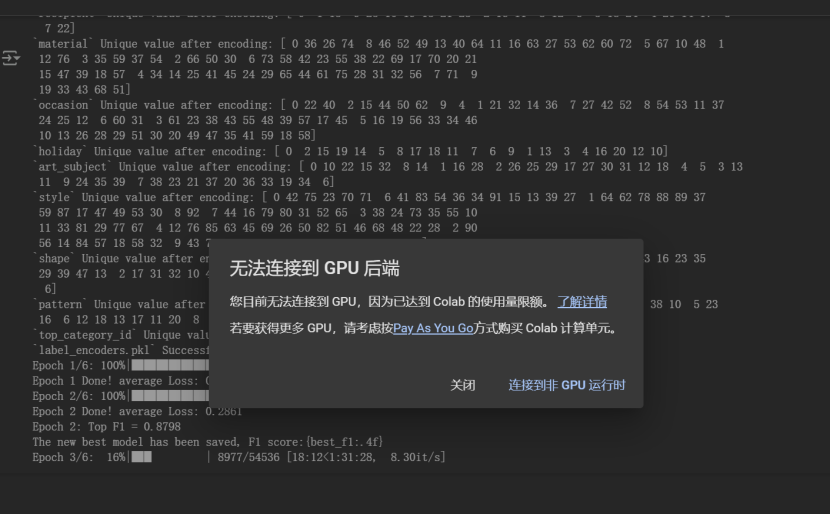

I initially used Google Colab for training. However, as shown in the screenshot, my free account exceeded the GPU usage quota. Therefore, I switched to training the model locally on my personal laptop.


 Finally, the F1 score of top_category_id is 90%.

This code fine-tunes a DistilBERT-based model to predict product categories using title, description, tags, and other categorical features. It loads and preprocesses the dataset, encodes categorical columns, tokenizes text, and feeds them into the model.

The model combines BERT text embeddings and categorical embeddings to make predictions. It uses cross-entropy loss, AdamW optimizer, and mixed precision for faster training. The model is trained over multiple epochs, and the best-performing model (based on macro F1-score on the validation set) is saved.

**How to solve the imbalance of top categories data?**

To address the data imbalance issue in top category prediction, I used class weights in the loss function. Specifically, I computed class weights using sklearn.utils.class_weight.compute_class_weight based on the frequency of each category. These weights were then passed to the CrossEntropyLoss function in PyTorch, allowing the model to pay more attention to underrepresented classes during training.

**What else can we get from the output?**

num_classes_top = 15:

This defines the number of output classes for the model. It means there are 15 unique top-level categories the model needs to predict.

num_categorical = 93:

This represents the total number of unique encoded values across all categorical columns. It is computed by taking the maximum value across all categorical columns after label encoding, and then adding 1.

# **5. Translate and Evaluate for Top Category Prediction**

**translate_test.py**

In [ ]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator

In [2]:
!pip install deep-translator
from deep_translator import GoogleTranslator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00


Before performing evaluation, I noticed that the test set is not entirely in English. Since my model only supports English input, translation is required.

In [ ]:
import os
import time
import pandas as pd
from googletrans import Translator
from deep_translator import GoogleTranslator


translator_detect = Translator()
translator_translate = GoogleTranslator(source="auto", target="en")


input_folder = r"/content/drive/MyDrive/2025/test"
output_folder = r"/content/drive/MyDrive/2025/test_clean"


os.makedirs(output_folder, exist_ok=True)


api_call_count = 0


TRANSLATION_DELAY = 1


def detect_language(text):
    try:
        detected_lang = translator_detect.detect(text).lang
        if detected_lang == "en":
            return "en"
        return detected_lang
    except Exception as e:
        print(f"error: {e}")
        return "unknown"


def translate_text(text):
    global api_call_count
    if pd.isna(text) or text.strip() == "":
        return text

    try:
        lang = detect_language(text)
        if lang == "en":
            return text


        for attempt in range(3):
            try:
                time.sleep(TRANSLATION_DELAY)
                translated_text = translator_translate.translate(text)
                api_call_count += 1

                return translated_text
            except Exception as e:

                time.sleep(1)

    except Exception as e:
        print(f"fail {text}, error: {e}")

    return text


def process_parquet_file(file_path):
    try:
        df = pd.read_parquet(file_path)


        columns_to_translate = ["title", "description", "tags"]
        for col in columns_to_translate:
            if col in df.columns:
                df[col] = df[col].apply(translate_text)


        output_file_path = os.path.join(output_folder, os.path.basename(file_path))
        df.to_parquet(output_file_path, index=False)

        print(f"{output_file_path}")
    except Exception as e:
        print(f" {file_path}, {e}")


parquet_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]


for file in parquet_files:
    process_parquet_file(file)



**evaluate.py**

In [ ]:
import torch
import pandas as pd
import joblib
import os
from tqdm import tqdm




model = DistilBERTCategoryClassifier(
    num_classes_top=15,
    num_categorical=93
).to(DEVICE)


model.load_state_dict(torch.load(
   r"/content/drive/MyDrive/2025/best_model_top.pth"
))
model.eval()



label_encoders = joblib.load(r"/content/drive/MyDrive/2025/label_encoders.pkl")

os.makedirs(PREDICT_DIR, exist_ok=True)


test_files = [f for f in os.listdir(TEST_DIR) if f.endswith(".parquet")]


for test_file in test_files:
    file_path = os.path.join(TEST_DIR, test_file)

    df_test = pd.read_parquet(file_path)


    df_test, _ = encode_categorical_safe(df_test)


    def prepare_batch(df, batch_size=BATCH_SIZE):
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i + batch_size]

            title_tokens = [tokenize_text(str(text)) for text in batch["title"]]
            desc_tokens = [tokenize_text(str(text)) for text in batch["description"]]
            tags_tokens = [tokenize_text(str(text)) for text in batch["tags"]]

            title_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
            title_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
            desc_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
            desc_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
            tags_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)
            tags_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)

            cats = torch.tensor(batch[CATEGORICAL_COLS].values, dtype=torch.long, device=DEVICE)

            yield title_input_ids, title_attention_mask, desc_input_ids, desc_attention_mask, tags_input_ids, tags_attention_mask, cats


    all_preds_top = []

    with torch.no_grad():
       for batch in prepare_batch(df_test):

            outputs_top = model(*batch[:7])
            preds_top = torch.argmax(outputs_top, dim=1).cpu().numpy()
            all_preds_top.extend(preds_top)


    df_test["top_category_id"] = [label_encoders[TARGET_COL].inverse_transform([x])[0] for x in all_preds_top]


    predict_file_path = os.path.join(PREDICT_DIR, test_file)
    df_test.to_parquet(predict_file_path, index=False)

    #print(f"save to {predict_file_path}")




This script loads a trained DistilBERT model and uses it to predict top categories for unseen test data.
It reads all .parquet files in the test directory and tokenizes title, description, and tags.
Categorical features are encoded, then batches are passed through the model to generate predictions.
Predicted class indices are decoded using saved label encoders and added to the DataFrame.
Finally, the updated results are saved to the prediction directory using the original filenames.

At this stage, I have already obtained the information for top_category_id.
Next, I need to predict bottom_category_id.
Therefore, I will include top_category_id as an input feature to improve the prediction of bottom_category_id.

# **6.Fine-tuned Model for Bottom Category**

**The following is the second model：**

**config.py**

In [10]:
import torch


#TRAIN_DIR = r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\train"
#TEST_DIR = r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\predict"
#PREDICT_DIR= r"C:\Users\zhou\Desktop\document\Spring 2025 CSC1145 Machine Learning (20430)\data_2025\2025\final_predict"

TRAIN_DIR = "/content/drive/MyDrive/2025/train"
TEST_DIR = "/content/drive/MyDrive/2025/predict"
PREDICT_DIR = "/content/drive/MyDrive/2025/final_predict"

MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 4
MAX_LEN = 64
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


TEXT_COLS = ["title", "description", "tags"]


CATEGORICAL_COLS = ["type", "room", "craft_type", "recipient", "material",
                    "occasion", "holiday", "art_subject", "style", "shape", "pattern", "top_category_id"]


TARGET_COL = "bottom_category_id"


The second model differs from the previous one in that it is used to predict the bottom_category_id and incorporates the previously predicted top_category_id as an additional input feature.

**model.py**

A DistilBERT-based classifier

In [7]:
import torch
import torch.nn as nn
from transformers import DistilBertModel


class DistilBERTCategoryClassifier(nn.Module):
    def __init__(self, num_classes, num_categorical, hidden_dim=128):
        super(DistilBERTCategoryClassifier, self).__init__()

        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.embedding = nn.Embedding(num_categorical, hidden_dim)
        self.fc_text = nn.Linear(768, hidden_dim)
        in_features = hidden_dim * 3 + len(CATEGORICAL_COLS) * hidden_dim
        self.fc_out = nn.Linear(in_features, num_classes)

    def forward(self, input_ids_title, attention_mask_title, input_ids_desc, attention_mask_desc, input_ids_tags, attention_mask_tags, cats):
        output_title = self.distilbert(input_ids=input_ids_title, attention_mask=attention_mask_title).last_hidden_state[:, 0, :]
        output_desc = self.distilbert(input_ids=input_ids_desc, attention_mask=attention_mask_desc).last_hidden_state[:, 0, :]
        output_tags = self.distilbert(input_ids=input_ids_tags, attention_mask=attention_mask_tags).last_hidden_state[:, 0, :]

        x_cats = self.embedding(cats).view(cats.size(0), -1)
        x_title = self.fc_text(output_title)
        x_desc = self.fc_text(output_desc)
        x_tags = self.fc_text(output_tags)

        x = torch.cat([x_title, x_desc, x_tags, x_cats], dim=1)
        out = self.fc_out(x)

        return out


**preprocess.py**

Handles data preprocessing for training and inference in a BERT-based classification task.

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer



tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_text(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
    return {"input_ids": tokens["input_ids"].squeeze(0), "attention_mask": tokens["attention_mask"].squeeze(0)}


def load_data(directory):
    import os
    parquet_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    df_list = [pd.read_parquet(file) for file in parquet_files]
    df = pd.concat(df_list, ignore_index=True)


    for col in TEXT_COLS:
        df[col] = df[col].astype(str).fillna("missing")


    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype(str).fillna("missing")

    return df


def encode_categorical(df):
    label_encoders = {}

    for col in CATEGORICAL_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise KeyError(f" `{col}` Does not exist 。")

        df[col] = df[col].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[col])
        df[col] = encoder.transform(df[col])
        label_encoders[col] = encoder

        print(f"`{col}` Unique value after encoding:{df[col].unique()}")

    return df, label_encoders


def encode_categorical_safe(df, skip_target_col=True):

    label_encoders = {}

    for col in CATEGORICAL_COLS:
        if col not in df.columns:
            print(f" `{col}`  Does not exist ")
            continue

        df[col] = df[col].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[col])
        df[col] = encoder.transform(df[col])
        label_encoders[col] = encoder

        print(f"`{col}` Unique value after encoding: {df[col].unique()}")

    if not skip_target_col and TARGET_COL in df.columns:
        df[TARGET_COL] = df[TARGET_COL].astype(str).fillna("missing")
        encoder = LabelEncoder()
        encoder.fit(df[TARGET_COL])
        df[TARGET_COL] = encoder.transform(df[TARGET_COL])
        label_encoders[TARGET_COL] = encoder
        print(f"`{TARGET_COL}`  {df[TARGET_COL].unique()}")

    return df, label_encoders


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**train.py**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import os
import joblib


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = load_data(TRAIN_DIR)


df, label_encoders = encode_categorical(df)


joblib.dump(label_encoders, "label_encoders.pkl")



num_embeddings = df[CATEGORICAL_COLS].max().max() + 1
print(f"`num_embeddings`  {num_embeddings}")


model = DistilBERTCategoryClassifier(
    num_classes=len(df[TARGET_COL].unique()),
    num_categorical=num_embeddings
).to(DEVICE)


optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


from torch.amp import autocast, GradScaler
scaler = GradScaler()


def prepare_batch(df, batch_size=BATCH_SIZE):
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]

        title_tokens = [tokenize_text(str(text)) for text in batch["title"]]
        desc_tokens = [tokenize_text(str(text)) for text in batch["description"]]
        tags_tokens = [tokenize_text(str(text)) for text in batch["tags"]]

        title_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
        title_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in title_tokens], dim=0).to(DEVICE)
        desc_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
        desc_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in desc_tokens], dim=0).to(DEVICE)
        tags_input_ids = torch.cat([t["input_ids"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)
        tags_attention_mask = torch.cat([t["attention_mask"].unsqueeze(0) for t in tags_tokens], dim=0).to(DEVICE)

        cats = torch.tensor(batch[CATEGORICAL_COLS].values, dtype=torch.long, device=DEVICE)
        labels = torch.tensor(batch[TARGET_COL].values, dtype=torch.long, device=DEVICE)

        yield title_input_ids, title_attention_mask, desc_input_ids, desc_attention_mask, tags_input_ids, tags_attention_mask, cats, labels


best_f1 = 0.0
best_model_path = "best_model_bottom.pth"


from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.05, random_state=42, stratify=df[TARGET_COL])


for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0
    total_batches = len(df_train) // BATCH_SIZE + (1 if len(df_train) % BATCH_SIZE > 0 else 0)
    progress_bar = tqdm(prepare_batch(df_train), total=total_batches, desc=f"Epoch {epoch}/{EPOCHS}")

    for batch in progress_bar:
        optimizer.zero_grad()

        with autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(*batch[:7])
            loss = criterion(outputs, batch[7])

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.update(1)

    print(f"Epoch {epoch} Loss: {epoch_loss / total_batches:.4f}")


    if epoch >= 2:
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in prepare_batch(df_val):
                outputs = model(*batch[:7])
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(batch[7].cpu().numpy())


        f1 = f1_score(all_labels, all_preds, average="macro")
        print(f"Epoch {epoch}: Bottom Category F1 = {f1:.4f}")


        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            print(f" F1  {best_f1:.4f}")




Epoch 1/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:24:01<00:00,  6.31it/s]
Epoch 1  Loss: 5.6013
Epoch 2/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:24:00<00:00,  6.31it/s]
Epoch 2  Loss: 2.9980
Epoch 2: Bottom Category F1: 0.3934
Epoch 3/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:17:16<00:00,  6.62it/s]
Epoch 3  Loss: 2.1772
Epoch 3: Bottom Category F1: 0.4764
Epoch 4/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:04:40<00:00,  7.29it/s]
Epoch 4  Loss: 1.7680
Epoch 4: Bottom Category F1: 0.5238
Epoch 5/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:15:09<00:00,  6.72it/s]
Epoch 5  Loss: 1.4822
Epoch 5: Bottom Category F1: 0.5456
Epoch 6/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:24:36<00:00,  6.29it/s]
Epoch 6  Loss: 1.2477
Epoch 6: Bottom Category F1: 0.5574
Epoch 7/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [2:15:25<00:00,  6.71it/s]
Epoch 7  Loss: 1.0590
Epoch 7: Bottom Category F1: 0.5659
Epoch 8/8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54536/54536 [1:59:22<00:00,  7.61it/s]
Epoch 8  Loss: 0.8999
Epoch 8: Bottom Category F1: 0.5703


Since my Colab account no longer had access to a GPU, I trained the model on my own laptop. As you can see, unlike top_category_id, the bottom_category_id has a much larger number of classes, making it more difficult for the current model to predict accurately. As a result, the F1 score is not very high.

# **7. Constrained Bottom Category Prediction using Top Category Filtering**

Before performing evaluation, I need to obtain the mapping between top_category_id and bottom_category_id, as well as between top_category_text and bottom_category_text, in order to further improve the F1 score.

**extract_category_mapping.py**


In [4]:
import pandas as pd
import os



folder_path = "/content/drive/MyDrive/2025/train"
def read_parquet_files_in_folder(folder_path):

    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".parquet")]
    if not all_files:

        return None


    dfs = []
    for file in all_files:
        try:
            df = pd.read_parquet(file, engine="pyarrow")

            dfs.append(df)
        except Exception as e:
            print(f" {file} error: {e}")


    if dfs:
        full_df = pd.concat(dfs, ignore_index=True)
        return full_df
    else:

        return None


df = read_parquet_files_in_folder(folder_path)


if df is not None:

    bottom_category_df = df[['bottom_category_id', 'bottom_category_text']].drop_duplicates()
    bottom_category_csv = "bottom_category.csv"
    bottom_category_df.to_csv(bottom_category_csv, index=False, encoding="utf-8-sig")



    top_category_df = df[['top_category_id', 'top_category_text']].drop_duplicates()
    top_category_csv = "top_category.csv"
    top_category_df.to_csv(top_category_csv, index=False, encoding="utf-8-sig")



In [5]:
import pandas as pd


bottom_category_path = r"bottom_category.csv"
top_category_path = r"top_category.csv"


bottom_df = pd.read_csv(bottom_category_path)
top_df = pd.read_csv(top_category_path)

top_category_dict = dict(zip(top_df["top_category_text"], top_df["top_category_id"]))


def find_top_category(bottom_text):
    for top_text, top_id in top_category_dict.items():
        if bottom_text.startswith(top_text):  # Judge the beginning match
            return top_id, top_text
    return None, None


bottom_df[["top_category_id", "top_category_text"]] = bottom_df["bottom_category_text"].apply(lambda x: pd.Series(find_top_category(x)))

merged_output_path = r"merged_categories.csv"
bottom_df.to_csv(merged_output_path, index=False)

print(f"The merge is complete and the file has been saved to: {merged_output_path}")


The merge is complete and the file has been saved to: merged_categories.csv


Now that I have the relationship between top_category and bottom_category, I can use this relationship to assist in the evaluation process.

**evaluate.py**

Constrained Prediction

In [ ]:
import torch
import pandas as pd
import joblib
import os
from tqdm import tqdm





model = DistilBERTCategoryClassifier(
    num_classes=2609,  # bottom_category
    num_categorical=93
).to(DEVICE)

model.load_state_dict(torch.load(
    r"/content/drive/MyDrive/2025/best_model_bottom.pth"
))

model.eval()



label_encoders = joblib.load("label_encoders.pkl")
bottom_category_encoder = label_encoders[TARGET_COL]


merged_category_path = r"/content/drive/MyDrive/2025/merged_categories.csv"
merged_df = pd.read_csv(merged_category_path)


merged_df["top_category_id"] = merged_df["top_category_id"].astype("int64")
merged_df["bottom_category_id"] = merged_df["bottom_category_id"].astype("int64")


top_to_bottom_map = merged_df.groupby("top_category_id")["bottom_category_id"].apply(set).to_dict()


original_to_encoded = {int(cat): idx for idx, cat in enumerate(bottom_category_encoder.classes_)}
encoded_to_original = {idx: int(cat) for idx, cat in enumerate(bottom_category_encoder.classes_)}


for k, v in list(encoded_to_original.items())[:10]:
    print(f"  {k}: {v} (: {type(v)})")


for k, v in list(top_to_bottom_map.items())[:5]:
    print(f"  {k}: {v}")

if not top_to_bottom_map:
    print("\n`top_to_bottom_map' is empty! Please check whether the data format of `merged _ df` is correct.")
else:
    print("\n`top_to_bottom_map` Generation succeeded.！")


os.makedirs(PREDICT_DIR, exist_ok=True)


test_files = [f for f in os.listdir(TEST_DIR) if f.endswith(".parquet")]


for test_file in test_files:
    file_path = os.path.join(TEST_DIR, test_file)


    df_test = pd.read_parquet(file_path)


    df_test["original_top_category_id"] = df_test["top_category_id"].astype("int64")


    df_test, _ = encode_categorical_safe(df_test)


    predicted_bottom_categories = []


    with torch.no_grad():
        for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
            product_id = row["product_id"]
            top_cat_id = row["original_top_category_id"]  # **Top_category_id before using coding**
            valid_bottoms = top_to_bottom_map.get(top_cat_id, set())  # **Get a legal set of' pre-coding' subclasses.**


            if not valid_bottoms:
                print(f" `valid_bottoms` is null, `top_cat_id={top_cat_id}` ")
                continue


            title_tokens = tokenize_text(str(row["title"]))
            desc_tokens = tokenize_text(str(row["description"]))
            tags_tokens = tokenize_text(str(row["tags"]))


            title_input_ids = title_tokens["input_ids"].unsqueeze(0).to(DEVICE)
            title_attention_mask = title_tokens["attention_mask"].unsqueeze(0).to(DEVICE)
            desc_input_ids = desc_tokens["input_ids"].unsqueeze(0).to(DEVICE)
            desc_attention_mask = desc_tokens["attention_mask"].unsqueeze(0).to(DEVICE)
            tags_input_ids = tags_tokens["input_ids"].unsqueeze(0).to(DEVICE)
            tags_attention_mask = tags_tokens["attention_mask"].unsqueeze(0).to(DEVICE)

            cats = torch.tensor([row[CATEGORICAL_COLS].values], dtype=torch.long, device=DEVICE)


            output = model(
                title_input_ids, title_attention_mask,
                desc_input_ids, desc_attention_mask,
                tags_input_ids, tags_attention_mask, cats
            )


            probs = torch.softmax(output, dim=1)
            sorted_preds = torch.argsort(probs, dim=1, descending=True).cpu().numpy().flatten()

            # **Select the first one by default (highest probability) *
            selected_pred_encoded = sorted_preds[0]  #  **Obtaining an' encoded' predicted value**
            selected_pred_original = int(encoded_to_original[selected_pred_encoded])  # **Decode to' before encoding', make sure it is' int'**

            top_30_preds_encoded = sorted_preds[:30]
            top_30_preds_original = [encoded_to_original[pred] for pred in top_30_preds_encoded]


            print(f"\nSample {idx} | product_id={product_id} | Target Top Category={top_cat_id} | Top Prediction={selected_pred_original} | Top 30 Predicted Categories={top_30_preds_original}")
            print(f"Selected Prediction: {selected_pred_original} (Valid)")


            # **Check the prediction results in turn until a legal subclass is found.**
            found_valid = False
            for pred_encoded in sorted_preds:
                pred_original = int(encoded_to_original[pred_encoded])  #  **Before converting back to encoding, make sure it is `int`.**
                if pred_original in valid_bottoms:
                    selected_pred_original = pred_original
                    found_valid = True
                    break


            if not found_valid:
                print(f"No legal category found, using the highest probability prediction.: {selected_pred_original}")

            predicted_bottom_categories.append(selected_pred_original)


    assert len(predicted_bottom_categories) == len(df_test), "The number of forecast categories does not match the data set length!"


    df_test["bottom_category_id"] = predicted_bottom_categories


    predict_file_path = os.path.join(PREDICT_DIR, test_file)
    df_test.to_parquet(predict_file_path, index=False)

    print(f" Forecast completed and saved to: {predict_file_path}")




Examples of output：


Sample 0 | product_id=635589100 | Target Top Category=6 | Top Prediction=6306 | Top 30 Predicted Categories=[6306, 1259, 326, 96, 1612, 1868, 71, 1597, 1866, 67, 2889, 299, 825, 60, 6837, 77, 1606, 6536, 1834, 6345, 70, 2850, 99, 2921, 2782, 2848, 2931, 6917, 6307, 2885]
Selected Prediction: 6306 (Valid)

Sample 1 | product_id=721674090 | Target Top Category=6 | Top Prediction=1259 | Top 30 Predicted Categories=[1259, 6306, 299, 6307, 71, 2921, 1612, 2931, 1597, 1314, 1303, 96, 119, 105, 6888, 1834, 300, 1868, 1866, 87, 12219, 99, 306, 2850, 892, 6788, 6712, 245, 304, 60]
Selected Prediction: 6306 (Valid)


This piece of code automatically corrects the model’s predictions. For example, in the first sample, the model correctly predicted a bottom_category_id that belongs to the corresponding top_category_id.

However, in the second sample, the model made an error.

Based on our earlier mapping table, we know that 6306 corresponds to "craft_supplies_and_tools.glue_and_adhesives.tape", while 1259 corresponds to "paper_and_party_supplies.paper.gift_wrapping.washi_tape".

These two categories both contain “tape”, making them hard to distinguish. By filtering out 1259 using the known top-level category, we selected 6306 instead.

This method relies on the assumption that top-level categories are predicted with higher accuracy, while bottom-level categories are more difficult to predict precisely.

# **8. Visualization**

**visualization.py**


Extracting embeddings: 100%|██████████| 25514/25514 [3:36:31<00:00,  1.96it/s]


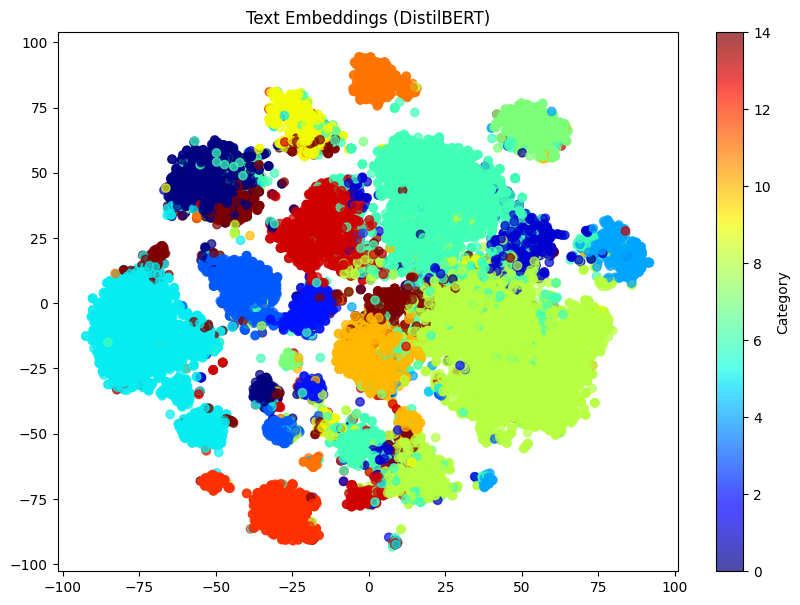

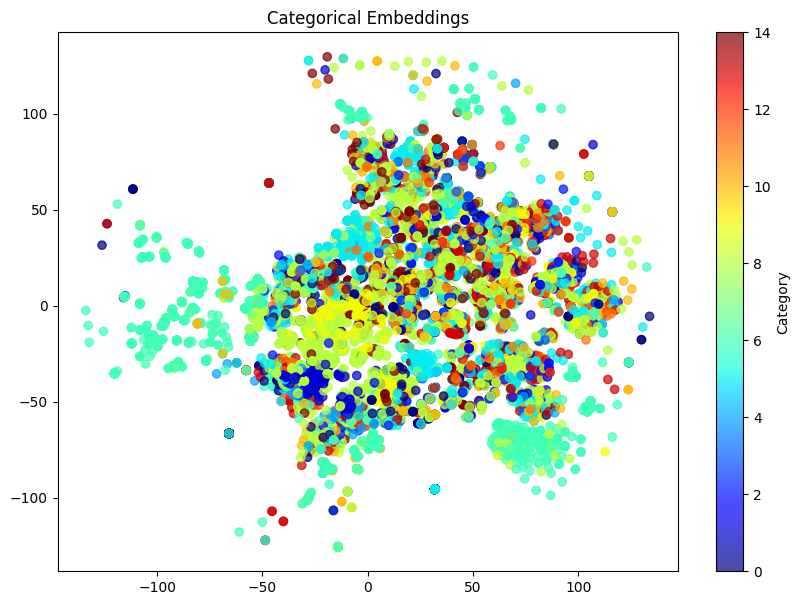

In [19]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import joblib
import os
from tqdm import tqdm


model = DistilBERTCategoryClassifier(
    num_classes_top=15,
    num_categorical=93
).to(DEVICE)

model.load_state_dict(torch.load(
      r"/content/drive/MyDrive/2025/best_model_top.pth",
      map_location=torch.device("cpu")
))
model.to(torch.device("cpu"))
model.eval()


label_encoders = joblib.load("/content/drive/MyDrive/2025/label_encoders.pkl")

test_files = [f for f in os.listdir(PREDICT_DIR) if f.endswith(".parquet")]

df_list = []
for test_file in test_files:
    df_test = pd.read_parquet(os.path.join(PREDICT_DIR, test_file))
    df_list.append(df_test)

df_test = pd.concat(df_list, ignore_index=True)



df_test["top_category_id"] = pd.to_numeric(df_test["top_category_id"], errors="coerce").fillna(0).astype(int)


df_test["top_category_label"] = label_encoders[TARGET_COL].inverse_transform(
    df_test["top_category_id"]
)



def extract_embeddings(df, model):
    text_features = []
    cat_features = []
    labels = []

    for i in tqdm(range(len(df)), desc="Extracting embeddings"):
        row = df.iloc[i]


        title_tokens = tokenize_text(str(row["title"]))
        desc_tokens = tokenize_text(str(row["description"]))
        tags_tokens = tokenize_text(str(row["tags"]))

        title_input_ids = title_tokens["input_ids"].unsqueeze(0).to(DEVICE)
        title_attention_mask = title_tokens["attention_mask"].unsqueeze(0).to(DEVICE)
        desc_input_ids = desc_tokens["input_ids"].unsqueeze(0).to(DEVICE)
        desc_attention_mask = desc_tokens["attention_mask"].unsqueeze(0).to(DEVICE)
        tags_input_ids = tags_tokens["input_ids"].unsqueeze(0).to(DEVICE)
        tags_attention_mask = tags_tokens["attention_mask"].unsqueeze(0).to(DEVICE)

        cats_values = row[CATEGORICAL_COLS].to_numpy()
        if cats_values.dtype == object:
            cats_values = np.array([int(x) for x in cats_values])
        cats = torch.tensor(cats_values, dtype=torch.long, device=DEVICE).unsqueeze(0)


        with torch.no_grad():
            output_title = model.distilbert(input_ids=title_input_ids, attention_mask=title_attention_mask).last_hidden_state[:, 0, :]
            output_desc = model.distilbert(input_ids=desc_input_ids, attention_mask=desc_attention_mask).last_hidden_state[:, 0, :]
            output_tags = model.distilbert(input_ids=tags_input_ids, attention_mask=tags_attention_mask).last_hidden_state[:, 0, :]
            x_cats = model.embedding(cats).view(1, -1)


        text_feature = torch.cat([output_title, output_desc, output_tags], dim=1).cpu().numpy()
        text_features.append(text_feature.flatten())
        cat_features.append(x_cats.cpu().numpy().flatten())


        labels.append(row["top_category_id"])

    return np.array(text_features), np.array(cat_features), np.array(labels)


text_embeddings, cat_embeddings, labels = extract_embeddings(df_test, model)


def visualize_embeddings(embeddings, labels, title="Embeddings Visualization"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="jet", alpha=0.7)
    plt.colorbar(scatter, label="Category")
    plt.title(title)
    plt.show()


visualize_embeddings(text_embeddings, labels, title="Text Embeddings (DistilBERT)")


visualize_embeddings(cat_embeddings, labels, title="Categorical Embeddings")


In the first diagram：

This plot shows the t-SNE projection of text embeddings generated by DistilBERT using title, description, and tags. Each point represents one product. Colors indicate different top-level category (0 to 14).

Clusters of similar colors suggest the model distinguishes those categories well. Overlapping colors mean some categories are semantically similar. This helps us understand how well BERT separates categories based on text.

Overall, DistilBERT performs well and is capable of distinguishing most categories effectively, making it suitable for the classification task.







In the second diagram：

This plot shows the t-SNE projection of the categorical feature embeddings learned by the model. Each point represents a product, with colors indicating its predicted top-level category (0 to 14).

Unlike the previous plot based on text features, this one appears more mixed and overlapping, suggesting that the categorical features alone (such as room, style, material, etc.) are not as effective at distinguishing categories. It implies that textual information plays a more important role in accurate classification.

Therefore, we should rely more on textual descriptions when classifying products, as they provide richer and more discriminative information compared to categorical features.

**predictions_A00013044.py**

In [ ]:
import os
import pandas as pd


final_predict_path = r"/content/drive/MyDrive/2025/final_predict"
test_path =  r"/content/drive/MyDrive/2025/test"


student_id = "A00013044"


def count_rows_in_parquet_dir(directory):
    parquet_files = [f for f in os.listdir(directory) if f.endswith(".parquet")]
    total_rows = 0

    for file in parquet_files:
        full_path = os.path.join(directory, file)
        df = pd.read_parquet(full_path)
        total_rows += len(df)

    return total_rows


final_predict_rows = count_rows_in_parquet_dir(final_predict_path)
test_rows = count_rows_in_parquet_dir(test_path)



if final_predict_rows == test_rows:



    parquet_files = [f for f in os.listdir(final_predict_path) if f.endswith(".parquet")]

    df_list = []
    for file in parquet_files:
        full_path = os.path.join(final_predict_path, file)
        df = pd.read_parquet(full_path, columns=["product_id", "original_top_category_id", "bottom_category_id"])


        df.rename(columns={"original_top_category_id": "top_category_id"}, inplace=True)

        df_list.append(df)


    df_final = pd.concat(df_list, ignore_index=True)


    output_file = f"predictions_{student_id}.parquet"
    df_final.to_parquet(output_file, index=False)


else:
    print(" The number of rows does not match. Please check！")


Finally, we merge the output from the second model into a single file for submission.